# Aufgabe 5 

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from matplotlib import pyplot
import ROC_AUC_Helper
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler

## a) 
Datensatz laden und erkunden

In [4]:
#Read the CSV File
hdma_df = pd.read_csv("Datasets/Hdma.csv",sep=";")

---------- Head of Dataset ----------
     dir    hir       lvr  ccs  mcs pbcr dmi self single  uria  condo black  \
0  0.221  0.221  0.800000  5.0  2.0   no  no   no     no   3.9      0    no   
1  0.265  0.265  0.921875  2.0  2.0   no  no   no    yes   3.2      0    no   
2  0.372  0.248  0.920398  1.0  2.0   no  no   no     no   3.2      0    no   
3  0.320  0.250  0.860465  1.0  2.0   no  no   no     no   4.3      0    no   
4  0.360  0.350  0.600000  1.0  1.0   no  no   no     no   3.2      0    no   

  deny  
0   no  
1   no  
2   no  
3   no  
4   no  
---------- Describe Dataset ----------
               dir          hir          lvr          ccs          mcs  \
count  2381.000000  2381.000000  2381.000000  2381.000000  2381.000000   
mean      0.330814     0.255346     0.737760     2.116387     1.721008   
std       0.107235     0.096635     0.178715     1.666370     0.537169   
min       0.000000     0.000000     0.020000     1.000000     1.000000   
25%       0.280000     0

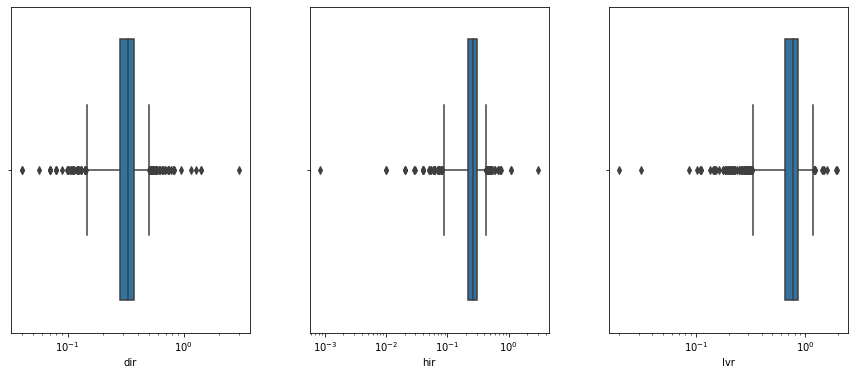

In [5]:
#---------------------- Exploration of the Dataset ----------------------
# Print Head and description of the dataset
print("---------- Head of Dataset ----------")
print(hdma_df.head())
print("---------- Describe Dataset ----------")
print(hdma_df.describe())

#Check if any value is Null  
print("---------- Null Check ----------")
print(hdma_df.isnull().any(axis=0))
null_data = hdma_df[hdma_df.isnull().any(axis=1)]
print(null_data)

#Check for imbalances
print("---------- Check Balance (Var: deny, black) ----------")
print(hdma_df['deny'].value_counts())
print(hdma_df['black'].value_counts())

#Plots to check for outliers
f, axes = plt.subplots(1, 3, figsize=(15, 6))
f.subplots_adjust(hspace=.3, wspace=.25)
plt1 = sns.boxplot(x=hdma_df['dir'], ax=axes[0])
plt1.set_xscale("log")
plt2 = sns.boxplot(x=hdma_df['hir'], ax=axes[1])
plt2.set_xscale("log")
plt3 = sns.boxplot(x=hdma_df['lvr'], ax=axes[2])
plt3.set_xscale("log")
plt.show()

Die Plots zeigen, dass die Variablen nicht mit schwerwiegenden Ausreißern behaftet sind.

In dem Datensatz sind nicht alle Zeilen vollständig, sondern es sind Null-Werte enthalten. Es ist jedoch nur eine Zeile betroffen, weshalb diese einfach entfernt werden kann.

Der Datensatz weist starke Imbalancen auf. Deny ist z.B. folgendermaßen verteilt: deny(yes):285, deny(no):2095. An dieser Stelle sei deshalb zu Aufgabe e) vorgegriffen.

## e) 
class_weight = ‚balanced‘ findet genau dann Verwendung, wenn die Zielklasse eine starke Imbalance aufweist. Das bedeutet, sollte in einem Datensatz das Verhältnis einer beispielsweise binären Variablen stark ungleich sein, also vermehrt True als False oder umgekehrt vorkommen, so wirkt sich dies später negativ auf die Fähigkeit zur korrekten Vorhersage des Models aus.
Die meisten Algorithmen für maschinelles Lernen gehen davon aus, dass die Daten innerhalb der Klassen gleichmäßig verteilt sind. Bei starkem Klassenungleichgewicht besteht das Problem darin, dass der Algorithmus stärker auf die Vorhersage der Mehrheitsklasse ausgerichtet ist. Der Algorithmus verfügt nicht über genügend Daten, um die in der Minderheitsklasse vorhandenen Muster zu lernen.
Dies ist auch in dem HDMA Datensatz so. Vergleicht man z.B. die Anzahl der Werte der Klasse deny, so stellt man fest, dass hier eine starke Imbalance vorliegt. Die Anzahl der deny_yes Werte (also dass ein Antrag abgelehnt wird) beträgt 285 wohingegen die Anzahl der deny_no Werte (also dass ein Antrag angenommen wird) bei 2095 liegt.
Ebenso ist es bei der Klasse black, welche die Hautfarbe der antragstellenden Person beschreibt. Das Verhältnis hier liegt bei 339 zu 2041 für black_yes zu black_no.

## b)
Grundsätzlich geht es bei der gestellten Aufgabe darum, aus einem bestehenden Datensatz herauszufinden welche Faktoren die Ablehnung eines Kreditantrags beeinflussen und insbesondere ob die Hautfarbe eines Antragstellers eine Rolle spielt.
Es handelt sich dabei also um eine Form der Klassifizierung. Klassifizierungsaufgaben fallen im Allgemeinen in den Bereich des machine learning Typs supervised learning. 
Um solch eine Klassifizierung, also eine Einteilung, ob z.B. ein Kreditantrag abgelehnt wird oder nicht, durchführen zu können, stehen verschiedene Methoden wie z.B. logistische Regression, decision tree, random forrest, etc. zur Verfügung.

## c) Vorverarbeitung

In [37]:
#--------------------- Preprocessing ----------------------
#Remove Rows with Null values
hdma_df.dropna(inplace=True)

#Perform one hot encoding to convert categorial variables into appropriate format and drop first column of each to avoid multicollinearity
preprocessed_df = pd.get_dummies(hdma_df, drop_first=True)

# Describe the now preprocessed dataset
print(preprocessed_df.describe())

#Normalization and separation
scaler = MinMaxScaler()
X = scaler.fit_transform(preprocessed_df.drop('deny_yes', axis=1).to_numpy())
y = preprocessed_df['deny_yes'].to_numpy()
cols = list(preprocessed_df.columns)[:-1]

               dir          hir          lvr          ccs          mcs  \
count  2380.000000  2380.000000  2380.000000  2380.000000  2380.000000   
mean      0.330814     0.255346     0.737776     2.116387     1.721008   
std       0.107257     0.096656     0.178751     1.666721     0.537282   
min       0.000000     0.000000     0.020000     1.000000     1.000000   
25%       0.280000     0.214000     0.652681     1.000000     1.000000   
50%       0.330000     0.260000     0.779536     1.000000     2.000000   
75%       0.370000     0.298825     0.868459     2.000000     2.000000   
max       3.000000     3.000000     1.950000     6.000000     4.000000   

              uria        condo     pbcr_yes      dmi_yes     self_yes  \
count  2380.000000  2380.000000  2380.000000  2380.000000  2380.000000   
mean      3.774496     0.288235     0.073529     0.020168     0.116387   
std       2.027062     0.453036     0.261058     0.140604     0.320755   
min       1.800000     0.000000     0

Es war Datenvorverarbeitung notwendig.
1. Null Werte: Eine Zeile enthielt Null Werte und wurde deshalb komplett entfernt.
2. Kategorische Variablen: Es waren kategorische Variablen im Datensatz enthalten. Diese mussten mittels z.B. One-Hot- Encoding in numerische Werte gewandelt werden. So wurde z.B. aus deny = yes/no, deny_yes= 1/0. Anmerkung: Pandas.get_dummies() erzeugt eigentlich zwei Spalten, wenn ein Feature binär ist. Für deny wären das die Spalten deny_yes und deny_no. Um Multikollinearität zu vermeiden wird eine der Spalten verworfen (drop_first = True).
3. Normalisierung: Die Hauptidee hinter Normalisierung / Standardisierung ist die folgende. Variablen, die in verschiedenen Maßstäben gemessen werden, tragen nicht gleichermaßen zur Modellanpassung und zur Modelllernfunktion bei und können zu einer Verzerrung führen. Um dieses potenzielle Problem zu lösen, wird daher vor der Modellanpassung eine merkmalsbezogene Normalisierung wie z.B. die MinMax-Skalierung durchgeführt.

## d) Train-Test-Split und logistische Regression

/usr/local/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/marvinwoller/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1904
Model:                          Logit   Df Residuals:                     1891
Method:                           MLE   Df Model:                           12
Date:                Sun, 09 May 2021   Pseudo R-squ.:                     inf
Time:                        15:36:02   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.3459      0.549    -11.558      0.000      -7.422      -5.270
dir           14.2440      3.497  

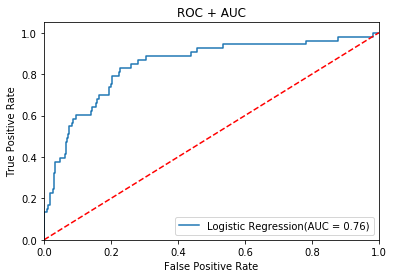

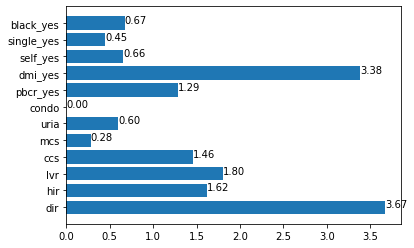

In [38]:
#Train-Test-Split: 80%:20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

#Logistic Regression with statsmodels (because sklearn has no support for significance values)
logit_model=sm.Logit(y_train,sm.add_constant(X_train))
result=logit_model.fit()
print(result.summary(xname=['intercept'] + cols)) 

#Logistic Regression with sklearn
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)

pred = logreg.predict(X_test)
print(logreg.score(X_test,y_test))

#Use helper function to create ROC plot with attached AUC value
ROC_AUC_Helper.makeROCandAUC(y_test,X_test,logreg,"Logistic Regression")

#Feature Importance
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	#print(cols[i] + ', Score: %.5f' % v)
    plt.text(v, i, '%.2f' % v)
# plot feature importance
pyplot.barh([x for x in cols], importance)
pyplot.show()

Da die logistische Regression mit sklearn keine Signifikanzwerte unterstützt wird diese zunächst mit statsmodels ausgeführt. 

Dabei wird ersichtlich, dass, in Bezug auf die Ablehnung eines Kreditantrags, die ausschlaggebenden Koeffizienten dir (14,24), dmi_yes (4.26), lvr (3.10), ccs (1.44) und pbcr_yes (1.45) sind. 
Ausgehend von einem standardmäßigen Signifikanzniveau von 0,05 sind diese Koeffizienten signifikant. Die Koeffizienten hir, mcs und condo übersteigen diesen Wert und sind damit nicht signifikant.
Da es auch insbesondere darum geht eine mögliche rassistische Diskriminierung zu erkennen, unterziehen wir den Koeffizienten black an dieser Stelle einer genaueren Betrachtung. Der Wert von black liegt bei 0.61, was, auch wenn er bei einem Signifikanzniveau von 0.05 signifikant ist, zwar positiv aber sehr gering ist und somit keine eindeutige Besonderheit in Bezug auf rassistische Diskriminierung darstellt. 

Die ROC Kurve steigt steil an und erzeugt einen einigermaßen akzeptabel AUC Wert von 0.76. 
Im folgenden wird mit weitern Modellen versucht hier auf noch bessere Werte zu kommen.

## f) Weitere Methoden

## Vergleichbarkeit von feature importance, Koeffizienten und log der Wahrscheinlichkeit
Die Ergebnisse der feature importances und die Koeffizienten können nicht direkt verglichen werden, da die Grundlage der Berechnung, ebenso wie die Skalierung der resultierenden Werte höchst unterschiedlich sind.

## Baseline: Häufigste Klasse

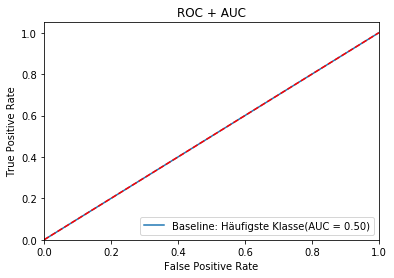

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       423
           1       0.00      0.00      0.00        53

    accuracy                           0.89       476
   macro avg       0.44      0.50      0.47       476
weighted avg       0.79      0.89      0.84       476



/Users/marvinwoller/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
### OTHER METHODS ###
#Baseline: Most frequent Class
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

#Perform prediction
#The result of a prediction would be a array full of 0 (Because deny_yes = 0 is the dominant class)
pred_dummy = dummy_clf.predict(X_test)

#Use helper function to create ROC plot with attached AUC value
ROC_AUC_Helper.makeROCandAUC(y_test,X_test,dummy_clf,"Baseline: Häufigste Klasse")

#Print a report aboute the models performance
print(classification_report(y_test, pred_dummy))

Als Baseline wird hier die Häufigste Klasse verwendet. Da die häufigste Klasse deny_yes = 0 ist und der Datensatz eine starke Imbalance aufweist, ergibt sich eine precision von 0.89 für 0 und 0.00 für 1.
Die ROC Kurve macht hier eigentlich keinen Sinn, da das Modell immer die selben Werte ausgibt (und eine Anpassung des Schwellwertes somit keinen Einfluss hat), ist aber der vollständigkeit halber trozdem mit angegeben. Der AUC Wert beträgt folglich 0.5.

## Decision Tree

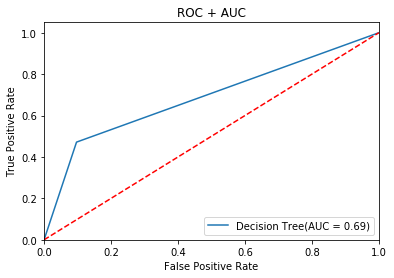

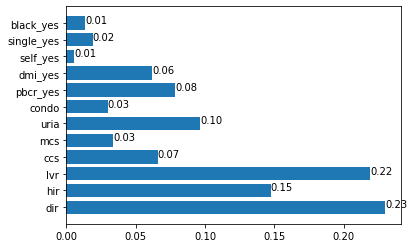

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       423
           1       0.38      0.47      0.42        53

    accuracy                           0.86       476
   macro avg       0.66      0.69      0.67       476
weighted avg       0.87      0.86      0.86       476



In [40]:
#Decision Tree
decision_tree_clf = DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
decision_tree_clf.fit(X_train, y_train)

#Perform prediction
pred_dt = decision_tree_clf.predict(X_test)

#Use helper function to create ROC plot with attached AUC value
ROC_AUC_Helper.makeROCandAUC(y_test,X_test,decision_tree_clf,"Decision Tree")

#Feature Importance
importance = decision_tree_clf.feature_importances_
for i,v in enumerate(importance):
#	print(cols[i] + ', Score: %.5f' % v)
    plt.text(v, i, '%.2f' % v)
pyplot.barh([x for x in cols], importance)
#plt.title('Feature importances')
pyplot.show()

#Print a report aboute the models performance
print(classification_report(y_test, pred_dt))

Die Performance des Decision Trees ist mit einem AUC Wert von 0.69 eher schlecht. Die Feature Importances sind daher auch nur sehr bedingt aussagekräftig. Die ausschlaggebenden Features sind hier lvr, dir und hir. Das black Feature spielt beim Decision Tree praktisch keine Rolle.

Im Vergleich mit den Feature Importances der logistischen Regression ist ebenfalls das dir, hir und lvr Feature von Bedeutung. dmi_yes und css sind beim Decision Tree weniger entscheidend. Das black Feature ist bei beiden nicht entscheidend.


## Random forrest

/Users/marvinwoller/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


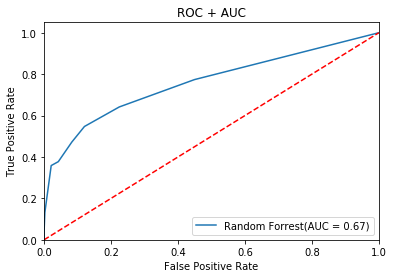

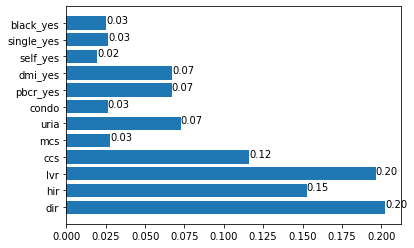

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       423
           1       0.68      0.36      0.47        53

    accuracy                           0.91       476
   macro avg       0.80      0.67      0.71       476
weighted avg       0.90      0.91      0.90       476



In [41]:
#Random Forrest
random_forrest_clf = RandomForestClassifier(class_weight='balanced')
random_forrest_clf.fit(X_train,y_train)

#Perform prediction
pred_rf = random_forrest_clf.predict(X_test)

#Use helper function to create ROC plot with attached AUC value
ROC_AUC_Helper.makeROCandAUC(y_test,X_test,random_forrest_clf,"Random Forrest")

#Feature Importance
importance = random_forrest_clf.feature_importances_
for i,v in enumerate(importance):
    plt.text(v, i, '%.2f' % v)
	#print(cols[i]+', Score: %.5f' % v)
pyplot.barh([x for x in cols], importance)
pyplot.show()

#Print a report aboute the models performance
print(classification_report(y_test, pred_rf))

Die Performance vom Random Forrest ist mit einem AUC Wert von 0.67 erneut schlecht.
Wie auch beim Decision Tree sind hier die ausschlaggebenden Features sind hier lvr, dir, hir und ccs. Das black feature spielt auch hier praktisch keine Rolle.

Die Verteilung der Feature Importances ist beim Random Forrest praktisch gleich wie beim Decision Tree. Im Vergleich mit den Feature Importances der logistischen Regression ist daher ebenfalls das dir, hir und lvr Feature von Bedeutung, dmi_yes und css sind weniger entscheidend und das black Feature ist ebenfalls nicht entscheidend.

## Adaboost

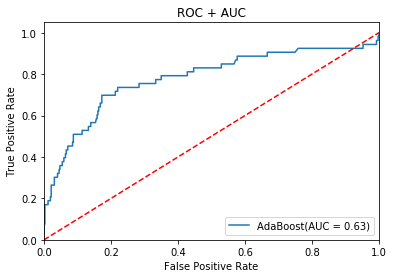

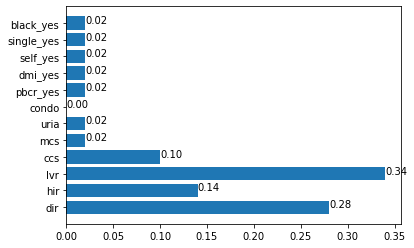

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       423
           1       0.50      0.30      0.38        53

    accuracy                           0.89       476
   macro avg       0.71      0.63      0.66       476
weighted avg       0.87      0.89      0.88       476



In [42]:
#AdaBoost
#adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(X_train, y_train)

#Perform prediction
pred_ada = adaboost_clf.predict(X_test)

#Use helper function to create ROC plot with attached AUC value
ROC_AUC_Helper.makeROCandAUC(y_test,X_test,adaboost_clf,"AdaBoost")

#Feature Importance
importance = adaboost_clf.feature_importances_
for i,v in enumerate(importance):
    plt.text(v, i, '%.2f' % v)
	#print(cols[i]+', Score: %.5f' % v)
pyplot.barh([x for x in cols], importance)
pyplot.show()

#Print a report aboute the models performance
print(classification_report(y_test, pred_ada))

Auch die Performance von Adaboost ist mit einem AUC Wert von 0.63 nicht gut.
Die ausschlaggebenden Features sind hier lvr gefolgt von dir. hir und ccs haben im Vergleich zu den anderen Features ebenfalls eine erhöhte Importance, liegen aber dennoch deutlich hinter lvr und dir. Das black Feature hat hier auch keine besondere Wichtigkeit.

Im Vergleich zur linearen Regression unterscheiden sich die Feature Importances hier stark. Auch wenn dir bei Adaboost hoch ist, ist es nicht das Feature mit der größten Importance, wie es bei der logistischen Regression der Fall war. Stattdessen ist hier lvr entscheidend, was bei der logistischen Regression weit weniger wichtig war. dmi_yes, welches bei der logistischen Regression das zweitwichtigste Feature war, ist bei Adaboost absolut unwichtig, ebenso wie alle anderen Features, abgesehen von dir, hir, lvr und ccs.

## Naive Bayes

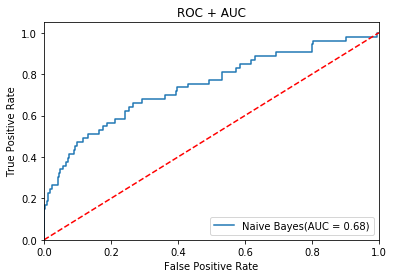

dir : 2.987600858922172
hir : 3.2425407817419645
lvr : 1.7621781236988285
ccs : 2.425128468649302
mcs : 2.2117245666326517
uria : 2.275567003252554
condo : 2.0294030098386964
pbcr_yes : 3.9054695855267454
dmi_yes : 6.5726977921087
self_yes : 2.9351116323823145
single_yes : 1.7348298420015875
black_yes : 2.888830879818308
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       423
           1       0.28      0.53      0.37        53

    accuracy                           0.80       476
   macro avg       0.61      0.68      0.62       476
weighted avg       0.86      0.80      0.82       476



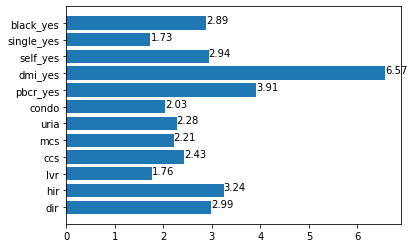

In [43]:
#Naive Bayes
complement_nb_clf = ComplementNB()
complement_nb_clf.fit(X_train, y_train)

#Perform prediction
pred_nb = complement_nb_clf.predict(X_test)

#Use helper function to create ROC plot with attached AUC value
ROC_AUC_Helper.makeROCandAUC(y_test,X_test,complement_nb_clf,"Naive Bayes")

for col, coef in zip(cols, complement_nb_clf.feature_log_prob_[1]):
  print(col + " : " + str(coef))
  
#Feature Importance
importance = complement_nb_clf.feature_log_prob_[1]
for i,v in enumerate(importance):
    plt.text(v, i, '%.2f' % v)
	#print(cols[i]+', Score: %.5f' % v)
pyplot.barh([x for x in cols], importance)
pyplot.show()

#Print a report aboute the models performance
print(classification_report(y_test, pred_nb))

Der Ansatz mit Naive Bayes liefert einen AUC Wert von 0.68. feature_log_prob liefert hier für die Features dmi_yes und pbcr_yes die höchsten Werte. Naive Bayes ist damit eines der wenigen Modelle welches dmi_yes und pbcr_yes ähnlich berücksichtigt wie die logistische Regression, auch wenn die Werte nicht direkt vergleichbar sind. 
Das black Feature spielt hier, im Gegensatz zu den anderen Modellen, zum ersten Mal eine wichtige Rolle.

SVM (linear kernel)

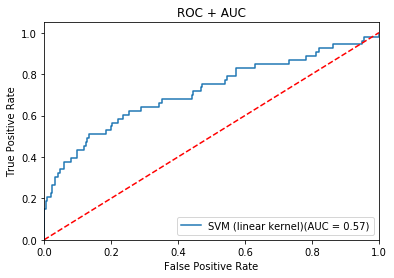

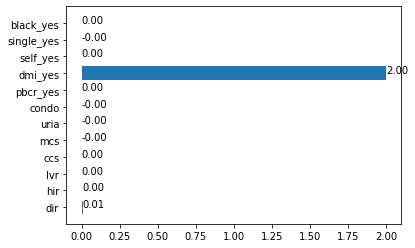

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       423
           1       1.00      0.13      0.23        53

    accuracy                           0.90       476
   macro avg       0.95      0.57      0.59       476
weighted avg       0.91      0.90      0.87       476



In [44]:
#SVM (linear kernel)
svm_clf = svm.SVC(kernel='linear' ,probability=True)
svm_clf.fit(X_train, y_train)

#Perform prediction
pred_svm = svm_clf.predict(X_test)

#Use helper function to create ROC plot with attached AUC value
ROC_AUC_Helper.makeROCandAUC(y_test,X_test,svm_clf,"SVM (linear kernel)")

importance = svm_clf.coef_[0]
for i,v in enumerate(importance):
    plt.text(v, i, '%.2f' % v)
	#print(cols[i]+', Score: %.5f' % v)
pyplot.barh([x for x in cols], importance)
pyplot.show()

#Print a report aboute the models performance
print(classification_report(y_test, pred_svm))

Die SVM hat mit 0.57 den schlechtesten AUC Wert. Das entscheidende Feature ist hier eindeutig dmi_yes.